In [2]:
%load_ext autoreload
%autoreload 2


from deepgreen import *
import pandas as pd
import json
from dotenv import load_dotenv
import os

from sentinelhub.api.catalog import SentinelHubCatalog

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    OsmSplitter,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    read_data,
    bbox_to_dimensions,
)
from utils import plot_image

In [3]:
# Init Config
load_dotenv()

CONFIG = SHConfig()
# TODO: Gaht nöd
CONFIG.sh_client_id = os.environ.get("CLIENT_ID")
CONFIG.sh_client_secret = os.environ.get("CLIENT_SECRET")
# Init Catalog
CATALOG = SentinelHubCatalog(config=CONFIG)

In [4]:
# AOI for Zürich (estimate)
AOI_ZH = BBox(bbox = (8.396073, 47.255932, 8.880802, 47.562627), 
              crs = CRS.WGS84)

In [16]:
AOI_ZH_segments = segment_aoi(aoi = AOI_ZH, resolution = 10, output = "grid")
BBOX = AOI_ZH_segments[0][0]

AOI has Dimensions: 3391px x 3673px (h x w)
AOI has been split into Grid with Dimensions: 3 x 3 (rows x cols)


In [29]:
TIME_INTERVALL = "2020-01-01", "2025-04-04"
MAX_CC = 20

In [7]:
AOI_BBOX_MAP = create_aoi_bbox_map(AOI_ZH_segments)
print(AOI_BBOX_MAP)

{'0000': BBox(((8.396073, 47.46039533333333), (8.557649333333332, 47.562627)), crs=CRS('4326')), '0001': BBox(((8.557649333333332, 47.46039533333333), (8.719225666666665, 47.562627)), crs=CRS('4326')), '0002': BBox(((8.719225666666667, 47.46039533333333), (8.880802, 47.562627)), crs=CRS('4326')), '0100': BBox(((8.396073, 47.35816366666667), (8.557649333333332, 47.46039533333334)), crs=CRS('4326')), '0101': BBox(((8.557649333333332, 47.35816366666667), (8.719225666666665, 47.46039533333334)), crs=CRS('4326')), '0102': BBox(((8.719225666666667, 47.35816366666667), (8.880802, 47.46039533333334)), crs=CRS('4326')), '0200': BBox(((8.396073, 47.255932), (8.557649333333332, 47.35816366666667)), crs=CRS('4326')), '0201': BBox(((8.557649333333332, 47.255932), (8.719225666666665, 47.35816366666667)), crs=CRS('4326')), '0202': BBox(((8.719225666666667, 47.255932), (8.880802, 47.35816366666667)), crs=CRS('4326'))}


In [30]:
AOI_CATALOG = create_aoi_catalog(CATALOG, TIME_INTERVALL, AOI_BBOX_MAP, save_file = False)
print(AOI_CATALOG)
AOI_CATALOG_X = {}
AOI_CATALOG_X['0000'] = AOI_CATALOG['0000']
AOI_DF = create_aoi_catalog_df_old_data(AOI_CATALOG_X)
# TODO: verschiedene Datentypen
AOI_DF.head()

{'0000': {'2025-04-03T10:37:44Z': 30.02, '2025-03-31T10:37:55Z': 74.31, '2025-03-31T10:27:49Z': 82.82, '2025-03-29T10:38:07Z': 99.72, '2025-03-28T10:27:57Z': 81.49, '2025-03-26T10:28:10Z': 99.41, '2025-03-24T10:37:48Z': 72.94, '2025-03-19T10:38:09Z': 0.04, '2025-03-18T10:28:01Z': 0.88, '2025-03-16T10:28:12Z': 98.72, '2025-03-14T10:37:47Z': 99.15, '2025-03-11T10:27:51Z': 49.0, '2025-03-09T10:38:09Z': 25.05, '2025-03-06T10:28:13Z': 0.0, '2025-03-04T10:37:48Z': 2.23, '2025-03-01T10:27:52Z': 80.02, '2025-02-27T10:38:10Z': 95.96, '2025-02-24T10:28:12Z': 99.46, '2025-02-22T10:37:50Z': 94.45, '2025-02-19T10:27:53Z': 89.04, '2025-02-17T10:38:08Z': 90.76, '2025-02-14T10:28:13Z': 98.83, '2025-02-12T10:37:49Z': 56.11, '2025-02-09T10:27:51Z': 45.45, '2025-02-07T10:38:12Z': 89.67, '2025-02-04T10:28:16Z': 51.92, '2025-02-02T10:37:48Z': 78.85, '2025-01-30T10:27:51Z': 97.71, '2025-01-28T10:38:13Z': 99.89, '2025-01-25T10:28:17Z': 21.94, '2025-01-23T10:37:47Z': 71.86, '2025-01-20T10:27:49Z': 71.59, '202

,AOI_ID,TS,CC,UID
0,0000,2025-04-03T10:37:44Z,30.02,0000_2025-04-03T10:37:44Z
1,0000,2025-03-31T10:37:55Z,74.31,0000_2025-03-31T10:37:55Z
2,0000,2025-03-31T10:27:49Z,82.82,0000_2025-03-31T10:27:49Z
3,0000,2025-03-29T10:38:07Z,99.72,0000_2025-03-29T10:38:07Z
4,0000,2025-03-28T10:27:57Z,81.49,0000_2025-03-28T10:27:57Z


In [31]:
AOI_CATALOG_2 = calculate_cc(AOI_CATALOG_X, AOI_BBOX_MAP, resolution = 10, CONFIG = CONFIG)
AOI_DF_2 = create_aoi_df_2(AOI_CATALOG_2)
AOI_DF_2.head()

Calculating Cloud Coverage
Estimated Time: 1870.0 seconds, 31.177666666666664 minutes


,AOI_ID,Timestamp,CC_API,CC_CLC
0,0000,2025-04-03T10:37:44Z,30.02,11.565745
1,0000,2025-03-31T10:37:55Z,74.31,77.620825
2,0000,2025-03-31T10:27:49Z,82.82,77.620825
3,0000,2025-03-29T10:38:07Z,99.72,100.000000
4,0000,2025-03-28T10:27:57Z,81.49,6.144761


In [ ]:
evalscript = load_evalscript("eval_scripts/es_true_color.js")
path_images = "images"
resolution = 10
for aoi_id in AOI_CATALOG_2.keys():
    aoi_recordings = AOI_CATALOG_2[aoi_id]
    aoi_bbox = AOI_BBOX_MAP[aoi_id]
    for recording in aoi_recordings.keys():
        timestamp = recording
        img = get_img(evalscript = evalscript, timestamp = str(timestamp)[:10], bbox = aoi_bbox, resolution = resolution, CONFIG = CONFIG)
        image_name = aoi_id+"_"+str(timestamp)[:10]+".png"
        download_img(img = img, path = path_images, filename = image_name)


In [17]:
evalscript = load_evalscript("eval_scripts/es_true_color_clm.js")
print(BBOX)
img = get_img(evalscript, "2024-11-29", BBOX, 10, CONFIG)

/var/folders/nt/2f26v76x6nq__8sxgl9bz2xr0000gn/T/ipykernel_10538/945412442.py:2: SHDeprecationWarning: The string representation of `BBox` will change to match its `repr` representation.
  print(BBOX)


8.396073,47.46039533333333,8.557649333333332,47.562627


In [ ]:
evalscript = load_evalscript("eval_scripts/es_true_color_clm.js")
img = get_img(evalscript, "2024-11-29", BBOX, 10, CONFIG)
download_img(img, "images", "test_image_clm.png")

In [26]:
evalscript = load_evalscript("eval_scripts/es_true_color.js")
img = get_img(evalscript, "2024-11-29", BBOX, 10, CONFIG)
download_img(img, "images", "test_image_rgb.png")

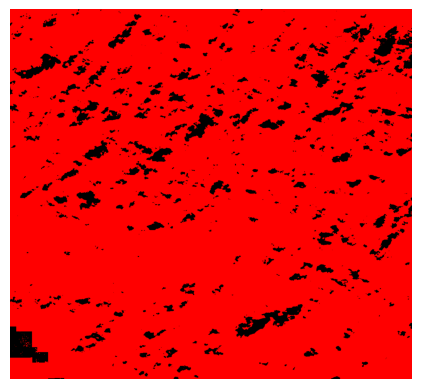

91.37861852778937

<Figure size 640x480 with 0 Axes>

In [25]:
calculate_red_coverage(img, red_threshold=50, factor=1.2)